## Construct a "nowcast" from multiple ESTOFS forecasts
* Using files downloaded from e.g. `noaa-gestofs-pds/estofs.20210927/estofs.t00z.conus.east.cwl.grib2`
* (tried reading in from AWS but was never successful)
* Forecasts are made very eight hours
* Discard the first four hours, which look noisy
* Concatenate hours 5 - 12 to make a best nowcast estimate
* Overlapping forecasets *could* be averaged...I did not do that
* Make some plots
* Convert the time stamp from `datetime64[ns]` to Matlab `datenum`
* Write the "nowcast" to a `.csv` file
* Some of the code was worked out using ChatGPT


In [1]:
import xarray as xr
import numpy as np
import s3fs
# import cfgrib # dont need this
import matplotlib.pyplot as plt
import datetime

In [2]:
dir_name = 'D:/crs/proj/2024_ESTOFS'
date_list = ['20210926', '20210927', '20210928']
# combined water level, tide prediction, surge water level
wl_list = ['cwl', 'htp', 'swl']
# no clue why cwl variable is unknown...that is them
var_list = ['unknown', 'elevhtml' ,'etsrg']
tz_list = ['t00z', 't06z', 't12z', 't18z']

In [3]:
# test reading in one example file
flist = []
for date in date_list:
    for tz in tz_list:
        flist.append( f"{dir_name}/{date}/estofs.{tz}.conus.east.{wl_list[2]}.grib2" )

print(flist)

# Open the GRIB2 file with xarray and cfgrib engine
ds = xr.open_dataset( flist[0], engine = 'cfgrib' )

# Print dataset info to inspect
ds

['D:/crs/proj/2024_ESTOFS/20210926/estofs.t00z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210926/estofs.t06z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210926/estofs.t12z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210926/estofs.t18z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210927/estofs.t00z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210927/estofs.t06z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210927/estofs.t12z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210927/estofs.t18z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210928/estofs.t00z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210928/estofs.t06z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210928/estofs.t12z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210928/estofs.t18z.conus.east.swl.grib2']


<xarray.Dataset> Size: 2GB
Dimensions:     (step: 181, y: 1377, x: 2145)
Coordinates:
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 1kB 00:00:00 01:00:00 ... 7 days 12:00:00
    surface     float64 8B ...
    latitude    (y, x) float64 24MB ...
    longitude   (y, x) float64 24MB ...
    valid_time  (step) datetime64[ns] 1kB ...
Dimensions without coordinates: y, x
Data variables:
    etsrg       (step, y, x) float32 2GB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-10-11T08:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# Find the closest grid point
lats = ds['latitude'].values
lons = ds['longitude'].values

latt = 35.716
lont = 360-75.4937

# Calculate the difference between the grid points and the target location
distance = np.sqrt((lats - latt)**2 + (lons - lont)**2)

# Find the index of the minimum distance (closest grid point)
min_index_flat = np.argmin(distance)

# Convert the flat index to row and column indices
min_index_2d = np.unravel_index(min_index_flat, distance.shape)
print('Indexes into 2D spatial array')
print(min_index_2d)
(idx, idy ) = min_index_2d
print(idx, idy)

Indexes into 2D spatial array
(np.int64(627), np.int64(1792))
627 1792


In [5]:
# extract the data to have a look
t = ds.time.values
ts = t+ds.step.values
z = ds.etsrg[:, idx, idy].values

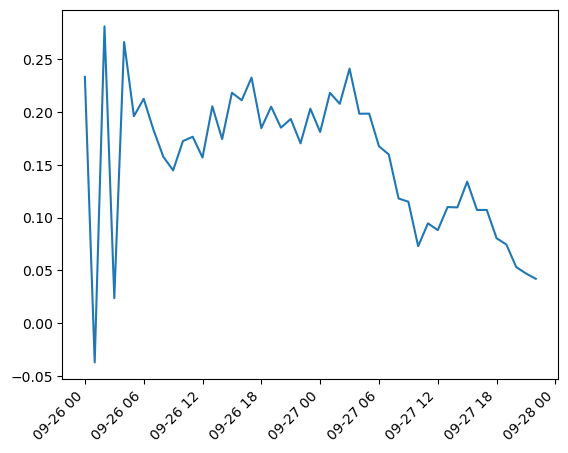

In [6]:
plt.plot(ts[0:47],z[0:47])
_ = plt.xticks(rotation=45, ha='right')

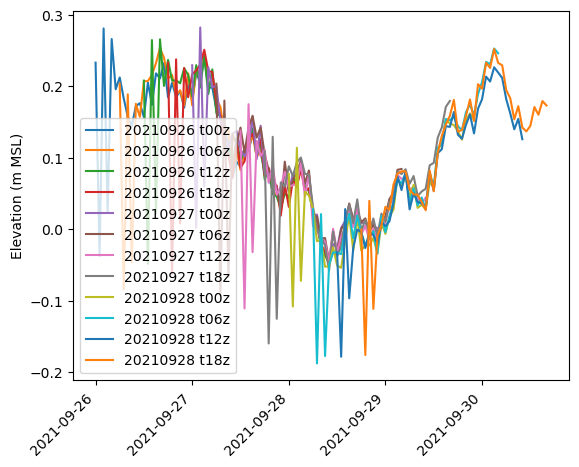

In [7]:
# Plot of overlapping forecasts
# (this is how we decided to skip the first four hours)
fig, ax = plt.subplots(1,1)

for date in date_list:
    for tz in tz_list:
        fname =  f"{dir_name}/{date}/estofs.{tz}.conus.east.{wl_list[2]}.grib2" 
        flabel = f"{date} {tz}"
        ds = xr.open_dataset( fname, engine = 'cfgrib' )
        t = ds.time.values
        ts = t+ds.step.values
        z = ds.etsrg[:, idx, idy].values
        plt.plot(ts[0:47],z[0:47],label=flabel)

plt.legend()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Elevation (m MSL)')
plt.savefig(dir_name+'/ESTOF_surge_elevations_multi_forecast.png', bbox_inches='tight', dpi=200)

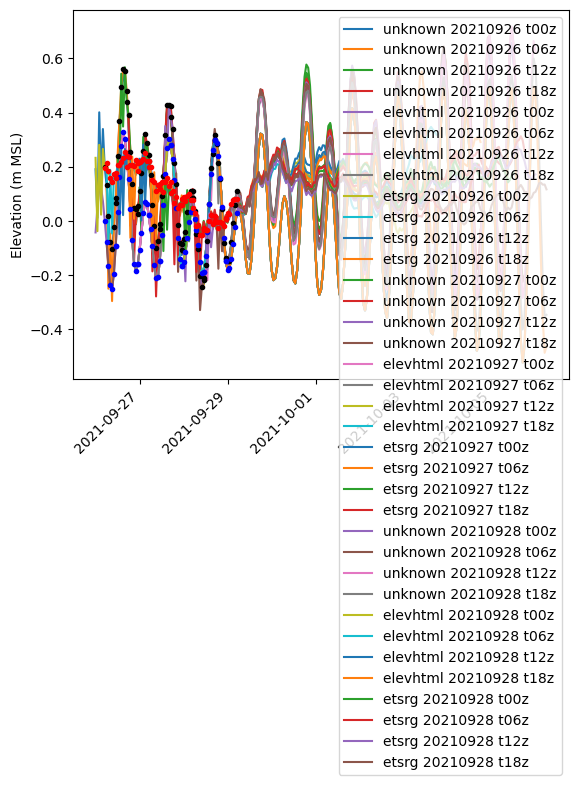

In [8]:
# Loop through the forecasts for several days in all three variable files
# Construct arrays for time, cwl, htp, and swl using hours 5:12 from each forecast.
# Make an ugly plot

fig, ax = plt.subplots(1,1)

tlong = np.array([], dtype='datetime64[ns]')
cwl = np.array([], dtype='float64')
htp = np.array([], dtype='float64')
swl = np.array([], dtype='float64')

for date in date_list:
    for i in range(3):
        var = var_list[i]
        for tz in tz_list:
            fname =  f"{dir_name}/{date}/estofs.{tz}.conus.east.{wl_list[i]}.grib2" 
            flabel = f"{var} {date} {tz}"
            ds = xr.open_dataset( fname, engine = 'cfgrib' )
            t = ds.time.values
            ts = t+ds.step.values
            zvalue = f'z=ds.{var}[:, idx, idy].values'
            exec(zvalue)
            tshort = ts[5:12]
            zshort = z[5:12]
            if i==0:
                tlong = np.concatenate( (tlong, np.array( tshort, dtype='datetime64[ns]') ))
                cwl = np.concatenate( (cwl, np.array( zshort, dtype='float64') ))
            elif i==1:
                htp = np.concatenate( (htp, np.array( zshort, dtype='float64') ))
            elif i==2:
                swl = np.concatenate( (swl, np.array( zshort, dtype='float64') ))
 
            plt.plot(ts,z,label=flabel)

plt.legend()
plt.plot(tlong, cwl, '.k',label='CWL')
plt.plot(tlong, htp, '.b',label='HTP')
plt.plot(tlong, swl, '.r',label='SWL')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Elevation (m MSL)')
plt.savefig(dir_name+'/ESTOF_surge_elevations_nowcast_forecast.png', bbox_inches='tight', dpi=200)

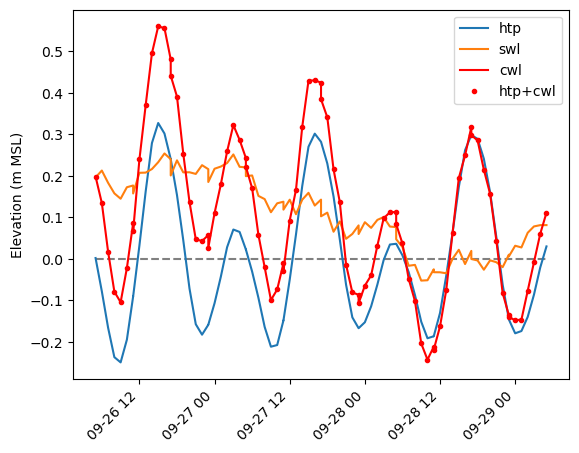

In [9]:
# plot the resulting 'nowcasts'
plt.plot(tlong, np.zeros_like(htp), '--', c='gray')
plt.plot(tlong, htp, label='htp')
plt.plot(tlong, swl, label='swl')
plt.plot(tlong, cwl, '-r', label='cwl' )
plt.plot(tlong, htp+swl, '.r',label='htp+cwl' )
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Elevation (m MSL)')
plt.savefig(dir_name+'/ESTOF_tide+surge.png', bbox_inches='tight', dpi=200)

In [10]:
# Convert the grib2 time (datetime64[ns]) to Matlab datenum

# Convert to seconds and then to list of datetimes
datetime_list = tlong.astype('datetime64[s]').tolist()  

def datetime_to_datenum(dt):
    '''
    Convert datetime64[s] to MATLAB datenum
    Input: list of datetime64[s] values
    Returns: list of Matlab datenum values
    '''
    matlab_epoch = datetime.datetime(1, 1, 1)  # MATLAB epoch (year 1, not year 0)
    days = (dt - matlab_epoch).days  # Difference in days from MATLAB epoch
    seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6  # Time in seconds
    return days + seconds / 86400  # Convert seconds to fractional day

# Convert the list of Python datetimes to MATLAB datenum
datenum_array = np.array([datetime_to_datenum(dt) for dt in datetime_list])

# Print MATLAB datenum values
print(datenum_array)

[738058.20833333 738058.25       738058.29166667 738058.33333333
 738058.375      738058.41666667 738058.45833333 738058.45833333
 738058.5        738058.54166667 738058.58333333 738058.625
 738058.66666667 738058.70833333 738058.70833333 738058.75
 738058.79166667 738058.83333333 738058.875      738058.91666667
 738058.95833333 738058.95833333 738059.         738059.04166667
 738059.08333333 738059.125      738059.16666667 738059.20833333
 738059.20833333 738059.25       738059.29166667 738059.33333333
 738059.375      738059.41666667 738059.45833333 738059.45833333
 738059.5        738059.54166667 738059.58333333 738059.625
 738059.66666667 738059.70833333 738059.70833333 738059.75
 738059.79166667 738059.83333333 738059.875      738059.91666667
 738059.95833333 738059.95833333 738060.         738060.04166667
 738060.08333333 738060.125      738060.16666667 738060.20833333
 738060.20833333 738060.25       738060.29166667 738060.33333333
 738060.375      738060.41666667 738060.4583333

In [11]:
# Write out the arrays in a CSV file
data2d = np.column_stack( (datenum_array, htp, swl, cwl) )
np.savetxt('dunex_estofs.csv', data2d, delimiter = ',', fmt='%.5f', header = 'datenum, htp, swl, cwl', comments=' ')